In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from collections import defaultdict
%matplotlib inline
from operator import truediv
from tokenize import group
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt

from matplotlib.lines import Line2D
import plotly.express as px
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
#new_porange = ListedColormap(newcolors)
import statsmodels.api as sm
def lstsq(x, y):
    A = np.vstack([x, np.ones(len(x))]).T
    coefs, *rest = np.linalg.lstsq(A, y, rcond=None)
    return coefs
plt.rcParams.update({'font.size': 15})

In [2]:
upstream_colors = {
    "LAION-80M": "blue",
    "LAION-400M": "orange",
    "LAION-2B": "green",
    "CLIP-WIT": "black",
}
upstream_colors2 = {
    "LAION-80M": "orange",
    "LAION-400M": "orange",
    "LAION-2B": "orange",
    "CLIP-WIT": "blue",
}
upstream_dataset_styles = {
    "LAION-80M": "v",
    "LAION-400M": "o",
    "LAION-2B": "s",
    "CLIP-WIT": "*",

}
upstream_order = ["LAION-80M", "LAION-400M", "LAION-2B", "CLIP WiT"]
samples_seen_sizes = {
    #"3B": 60,
    #"13B": 100,
    #"34B": 180,
    #"3B": 100,
    "13B": 150,
    "34B": 300,
}
samples_seen_order = ["13B", "34B"]
arch_order = ["ViT-B/32", "ViT-B/16", "ViT-L/14", "ViT-H/14", "ViT-g/14"]
arch_sizes = {
    "ViT-B/32": 40, 
    "ViT-B/16": 80, 
    "ViT-L/14": 120,
    "ViT-H/14": 160, 
    "ViT-g/14": 200,
}
model_styles = {
    "ViT-B/32": "v", 
    "ViT-B/16": "o", 
    "ViT-L/14": "s",
    "ViT-H/14": "P", 
    "ViT-g/14": "*",

}
upstream_sizes = {
    "LAION-80M": 60,
    "LAION-400M": 100,
    "LAION-2B": 180,
    "CLIP-WIT": 100,
}

In [3]:
def build_df2(target='imagenet1k-unverified', fewshot_k=10):
    target_pretty = {
        "imagenet1k": "ImageNet",
        "mscoco_captions": "MS-COCO",
        "vtab+": "VTAB+",
        "vtab": "VTAB",
        "imagenet_robustness": "ImageNet robustness",
        "flickr30k": "Flickr30K",
        "imagenet1k-unverified" : "ImageNet",
        "cifar100" : "CIFAR100",
    }[target]
    metric = 'err1%'
    metric_pretty = {
        'acc1%': 'Top-1 accuracy %',
        'err1%': 'Error rate %',
        "image_retrieval_recall@5%": 'Image retrieval Recall@5'
    }[metric]
    metric_pretty2 = {
        'err1%': 'error rate (%)',
        "image_retrieval_recall@5%": '(100 - Recall@5%)'
    }[metric]

    metric_higher_is_better ={
        "image_retrieval_recall@5%": True,
        "acc1%": True,
        "err1%": False,
    }[metric]

    d = newdf[(newdf.dataset==target) & (newdf.fewshot_k == fewshot_k)].copy()
    
    def f(s):
        return {
            #'LAION-80M': 80e6,
            'LAION-400M': 400e6,
            'LAION-2B': 2e9,
            'CLIP-WIT': 400e6,
        }[s]
    d['data_scale'] = d.upstream_dataset.apply(f)
    d['err1'] = 1 - (d['image_retrieval_recall@5'] if metric == 'image_retrieval_recall@5%' else d['lp_acc1'])
    #d['image_retrieval_recall@5%'] = d['image_retrieval_recall@5'] * 100.0
    d['acc1%'] = d['lp_acc1'] * 100.0
    d['err1%'] = d['err1'] * 100.0
    d['arch_pretty'] = d.model.apply(lambda a:'-'.join(a.split('-')[0:-1]) + '/' + a.split('-')[-1])
    d['Model']  = d['arch_pretty']
    d['Model Data'] = d.apply(lambda r:r['Model'] + ' ' + r['upstream_dataset'], axis=1)
    d['Dataset'] = d['upstream_dataset']
    d['Samples seen'] = d['samples_seen_pretty']
    d = d.sort_values(by=metric)
    d['Dataset source'] = d.upstream_dataset.apply(lambda u:"CLIP-WIT" if u == "CLIP-WIT" else "LAION")
    d = d[d.model != "ViT-B-16-plus"]
    print(len(d))
    print(d[d.model == 'ViT-B-32'])
    d = d.sort_values(by=metric).drop_duplicates(subset=["samples_seen_pretty", "model", "upstream_dataset"], keep='first')
    print(len(d))
    d = d.sort_values(by='gmacs_total')
    openai = (d.upstream_dataset=="CLIP-WIT")
    openclip = ~openai
    d_openclip = d[openclip]
    d_openai = d[openai]
    return d, d_openai, d_openclip, target_pretty, metric_pretty, metric_pretty2, metric

108
      k     lr   bs  epochs     model         pretrained pretrained_short  \
73   10  0.010  256      40  ViT-B-32  laion2b_s34b_b79k          laion2b   
64   10  0.010  256      20  ViT-B-32  laion2b_s34b_b79k          laion2b   
208  10  0.010  256      40  ViT-B-32        laion2b_e16          laion2b   
54   10  0.100  256      10  ViT-B-32  laion2b_s34b_b79k          laion2b   
63   10  0.100  256      20  ViT-B-32  laion2b_s34b_b79k          laion2b   
72   10  0.100  256      40  ViT-B-32  laion2b_s34b_b79k          laion2b   
199  10  0.010  256      20  ViT-B-32        laion2b_e16          laion2b   
189  10  0.100  256      10  ViT-B-32        laion2b_e16          laion2b   
198  10  0.100  256      20  ViT-B-32        laion2b_e16          laion2b   
207  10  0.100  256      40  ViT-B-32        laion2b_e16          laion2b   
19   10  0.010  256      40  ViT-B-32      laion400m_e32    laion400m_e32   
46   10  0.010  256      40  ViT-B-32             openai           opena

/private/home/mitchellw/miniconda3/envs/cb/lib/python3.10/site-packages/seaborn/_oldcore.py:200: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:
/private/home/mitchellw/miniconda3/envs/cb/lib/python3.10/site-packages/seaborn/_oldcore.py:200: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:
/private/home/mitchellw/miniconda3/envs/cb/lib/python3.10/site-packages/seaborn/_oldcore.py:200: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:


$E = 5.18 \/*\/ C^{ -0.12 }$
108
      k     lr   bs  epochs     model         pretrained pretrained_short  \
387  10  0.100  256      20  ViT-B-32  laion2b_s34b_b79k          laion2b   
378  10  0.100  256      10  ViT-B-32  laion2b_s34b_b79k          laion2b   
397  10  0.010  256      40  ViT-B-32  laion2b_s34b_b79k          laion2b   
396  10  0.100  256      40  ViT-B-32  laion2b_s34b_b79k          laion2b   
522  10  0.100  256      20  ViT-B-32        laion2b_e16          laion2b   
531  10  0.100  256      40  ViT-B-32        laion2b_e16          laion2b   
513  10  0.100  256      10  ViT-B-32        laion2b_e16          laion2b   
388  10  0.010  256      20  ViT-B-32  laion2b_s34b_b79k          laion2b   
532  10  0.010  256      40  ViT-B-32        laion2b_e16          laion2b   
379  10  0.010  256      10  ViT-B-32  laion2b_s34b_b79k          laion2b   
523  10  0.010  256      20  ViT-B-32        laion2b_e16          laion2b   
398  10  0.001  256      40  ViT-B-32  laio

/private/home/mitchellw/miniconda3/envs/cb/lib/python3.10/site-packages/seaborn/_oldcore.py:200: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:
/private/home/mitchellw/miniconda3/envs/cb/lib/python3.10/site-packages/seaborn/_oldcore.py:200: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:
/private/home/mitchellw/miniconda3/envs/cb/lib/python3.10/site-packages/seaborn/_oldcore.py:200: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:


$E = 27.89 \/*\/ C^{ -0.18 }$
108
     k     lr   bs  epochs     model         pretrained pretrained_short  \
403 -1  0.010  256      40  ViT-B-32  laion2b_s34b_b79k          laion2b   
394 -1  0.010  256      20  ViT-B-32  laion2b_s34b_b79k          laion2b   
384 -1  0.100  256      10  ViT-B-32  laion2b_s34b_b79k          laion2b   
538 -1  0.010  256      40  ViT-B-32        laion2b_e16          laion2b   
393 -1  0.100  256      20  ViT-B-32  laion2b_s34b_b79k          laion2b   
529 -1  0.010  256      20  ViT-B-32        laion2b_e16          laion2b   
385 -1  0.010  256      10  ViT-B-32  laion2b_s34b_b79k          laion2b   
519 -1  0.100  256      10  ViT-B-32        laion2b_e16          laion2b   
528 -1  0.100  256      20  ViT-B-32        laion2b_e16          laion2b   
402 -1  0.100  256      40  ViT-B-32  laion2b_s34b_b79k          laion2b   
520 -1  0.010  256      10  ViT-B-32        laion2b_e16          laion2b   
404 -1  0.001  256      40  ViT-B-32  laion2b_s34b_b79

/tmp/ipykernel_173601/2074057257.py:208: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


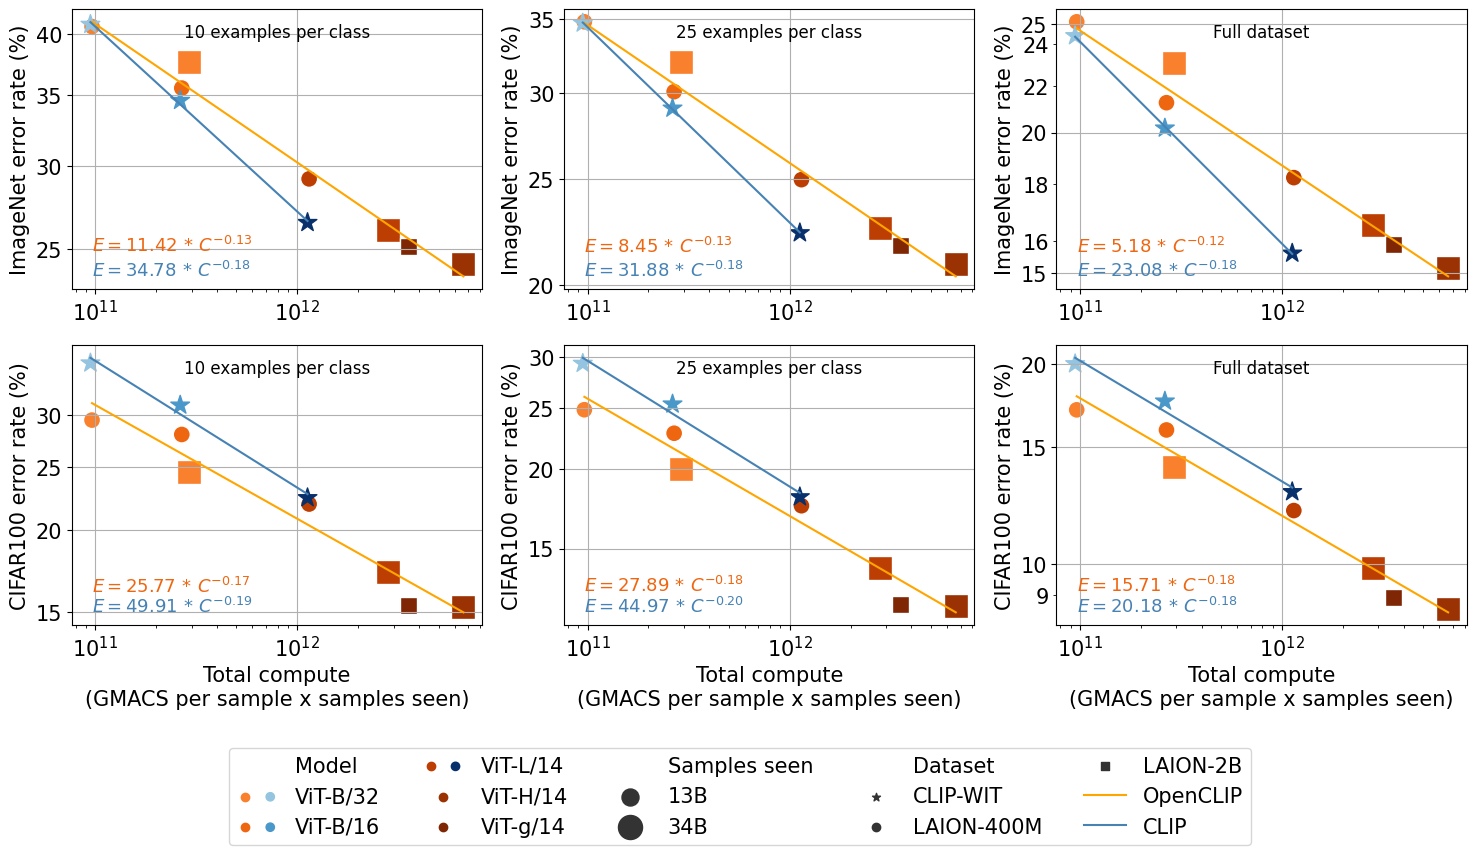

In [4]:
newdf = pd.read_json('scaling_experiment_data2.json')
figsize = (18,8)
from matplotlib.legend_handler import HandlerTuple
from matplotlib.patches import Patch
import matplotlib.patches as mpatches
from matplotlib.legend_handler import HandlerTuple
from copy import copy
from matplotlib.lines import Line2D
fig, axes = plt.subplots(nrows=2, ncols=3, constrained_layout=True, figsize=figsize)
porange = cm.get_cmap('Oranges', 12)
new_porange = porange(np.linspace(0.5, 1, len(arch_order) ))
#task = "imagenet"
#task = "retrieval"
# names = {
#     "imagenet": ('imagenet1k', 'imagenet_robustness'),
#     "retrieval": ('mscoco_captions', 'flickr30k'),
# }[task]
names = ('imagenet1k-unverified', 'imagenet1k-unverified', 'imagenet1k-unverified', 'cifar100', 'cifar100', 'cifar100')
#for ax, tgt in zip(axes, ('imagenet1k', 'mscoco_captions')):
#for ax, tgt in zip(axes, ('imagenet1k', 'vtab')):
#for ax, tgt in zip(axes, ('imagenet1k', 'imagenet_robustness')):
#for ax, tgt in zip(axes, ('imagenet1k', 'mscoco_captions')):
#for ax, tgt in zip(axes, ('mscoco_captions', 'flickr30k')):
def get_formula_text(coefs):
    return f"$E = {10**(coefs[1]):.2f} \/*\/ C^{{ {coefs[0]:.2f} }}$"
def get_rotn(x0, y0, x1, y1):
    p1 = ax.transData.transform_point((x0, y0))
    p2 = ax.transData.transform_point((x1, y1))
    dy = (p2[-1] - p1[-1])
    dx = (p2[0] - p1[0])
    return np.degrees(np.arctan2(dy, dx))

for ii, tgt in enumerate(names):
    iimod3 = ii % 3
    iidiv3 = ii // 3
    ax = axes[iidiv3, iimod3]
    fewshot_k = [10, 25, -1][iimod3]

    d, d_openai, d_openclip, target_pretty, metric_pretty, metric_pretty2, metric = build_df2(tgt, fewshot_k)
    line_fit_loglog_openclip = lstsq(np.log10(d_openclip.gmacs_total), np.log10(d_openclip.err1))
    line_fit_loglog_openai = lstsq(np.log10(d_openai.gmacs_total), np.log10(d_openai.err1))
    print(tgt, line_fit_loglog_openclip, line_fit_loglog_openai)
    d["styles"] = d.upstream_dataset.apply(lambda f:upstream_dataset_styles[f])
    #d = d.sort_values(by="gmacs")
    d = d.sort_values(by=["Dataset source", "data_scale"])
    sns.scatterplot(
        #data=d[d.upstream_dataset != "LAION-80M"],
        #data=d_openclip.sort_values(by="data_scale"),
        data=d,
        x='gmacs_total',
        y='err1%',

        #hue='Dataset',
        #palette=upstream_colors2,
        #hue_order=upstream_order + ["CLIP-WIT"],

        hue="Model",
        #palette="Oranges",
        palette=new_porange,
        hue_order=arch_order,

        #size="Dataset",
        #size_order=upstream_order,
        #sizes=upstream_sizes,

        size="Samples seen",
        size_order=samples_seen_order,
        sizes=samples_seen_sizes,

        #size="Model",
        #size_order=arch_order,
        #sizes=arch_sizes,

        style='Dataset',
        markers=upstream_dataset_styles,

        #style="Model",
        #markers=model_styles,

        ax=ax,
        #color='blue',
        #alpha=0.5,
        #style='+',
        s=120,
        #alpha=0.8
    )
    def pred(g, params):
        a, b = params
        return 10**(b) * g**a
    d = d.sort_values(by='gmacs_total')
    
    # OpenCLIP line
    x = d_openclip.gmacs_total.values
    y = (100* pred(d_openclip.gmacs_total, line_fit_loglog_openclip)).values
    ax.plot(x, y, color='orange', label='OpenCLIP')#, linestyle='dashed')
    #rotn = get_rotn(x[0], y[0], x[-1], y[-1])+5
    #ax.annotate(get_formula_text(line_fit_loglog_openclip), xy=(x[0],y[0]-1.5), ha='center', va='center', rotation=rotn, fontsize=13)
    xm = x.min()
    ym = y.min()
    shift = (y[-1] - y[-2]) * 0.65
    print(get_formula_text(line_fit_loglog_openclip))
    ax.annotate(get_formula_text(line_fit_loglog_openclip), xy=(xm, ym-shift), rotation=0, fontsize=13, color=new_porange[1])
    #ax.annotate(get_formula_text(line_fit_loglog_openclip), xy=(xm, ym+1), rotation=0, fontsize=13, color=new_porange[1])
    # OpenAI line
    x = d_openai.gmacs_total.values
    y = 100*pred(d_openai.gmacs_total, line_fit_loglog_openai).values
    ax.plot(x, y, color='steelblue', ms=10, label="CLIP")
    openai_cols = cm.get_cmap('Blues')
    openai_cols = [openai_cols(0.4), openai_cols(0.6), openai_cols(1.0)]
    ax.scatter(d_openai.gmacs_total.values, d_openai['err1%'].values, marker='*', s=200, c=openai_cols)
        
    #rotn = get_rotn(x[0], y[0], x[-1], y[-1])+5
    #ax.annotate(get_formula_text(line_fit_loglog_openai), xy=(x[0],y[0]-8), ha='center', va='center', rotation=rotn, fontsize=13)
    ax.annotate(get_formula_text(line_fit_loglog_openai), xy=(xm, ym),rotation=0, fontsize=13, color='steelblue')

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%d'))
    ax.yaxis.set_minor_formatter(mticker.ScalarFormatter())
    if iimod3 == 0:
        ax.text(.5,.9,'10 examples per class',
            horizontalalignment='center',
            transform=ax.transAxes, fontsize=12)
    elif iimod3 == 1:
        ax.text(.5,.9,'25 examples per class',
            horizontalalignment='center',
            transform=ax.transAxes, fontsize=12)
    elif iimod3 == 2:
        ax.text(.5,.9,'Full dataset',
            horizontalalignment='center',
            transform=ax.transAxes, fontsize=12)

    ax.set_ylabel(f"{target_pretty} {metric_pretty2}")
    ax.grid(True)
    if ii == 0:
        ax.set_yticks([25, 30, 35, 40] )
    elif ii == 1:
        ax.set_yticks([20, 25, 30, 35] )

    elif ii == 2:
        ax.set_yticks([15, 20, 25] )
    elif ii == 3:
        ax.set_yticks([15, 20, 25, 30] )
    elif ii == 4:
        ax.set_yticks([15, 20, 25, 30] )
    elif ii == 5:
        ax.set_yticks([10,15, 20] )
    if ii == 5:
        #ax.legend(bbox_to_anchor=(-1,-0.4), ncol=5, )
        #lab, hand = ax.get_axis_labels_handles()
        #ax.legend(lab, hand, bbox_to_anchor=(0.5,-0.4), ncol=5, )#.legendHandles[-1]._legmarker.set_marker('*')
        handles, labels = ax.get_legend_handles_labels()#
        start = 3-2
        end = 6-2
        for i in range(start, end):
            hnew = copy(handles[i])
            hnew.set_facecolors([openai_cols[i-start], "none"])
            hnew.set_edgecolors([openai_cols[i-start], "none"])
            handles[i] = (handles[i], hnew)
        #handles[-1] = Line2D([0], [0], color='steelblue',ms=10, label="CLIP", marker='*')
        # handles = handles[-2:] + handles[:-2]
        # labels = labels[-2:] + labels[:-2]
        ax.legend(handles, labels, bbox_to_anchor=(0.5,-0.4), ncol=5, handler_map={tuple: HandlerTuple(ndivide=None)})
    
        #ax.legend(h, l, bbox_to_anchor=(0.5,-0.4), ncol=5, )
        
    else:
        ax.legend().set_visible(False)
    
    # sns.scatterplot(
    #     #data=d[d.upstream_dataset != "LAION-80M"],
    #     data=d_openai.sort_values(by="data_scale"),
    #     #data=d,
    #     x='gmacs_total',
    #     y='err1%',

    #     #hue='Dataset',
    #     #palette=upstream_colors2,
    #     #hue_order=upstream_order + ["CLIP-WIT"],

    #     hue="Dataset",

    #     # size="Samples seen",
    #     # size_order=samples_seen_order,
    #     # sizes=samples_seen_sizes,
    #     s = 400,

    #     style='Dataset',
    #     markers=upstream_dataset_styles,

    #     ax=ax,
    #     legend=False
    # )
    if ii > 2:
        ax.set_xlabel("Total compute\n(GMACS per sample x samples seen)")
    else:
        ax.set_xlabel(None)
    #ax.legend().set_visible(False)
    
#plt.yticks(np.arange(int(d[metric].min())-2, int(d[metric].max())+2, 10))
#plt.legend(loc='best')
#plt.yticks([50, 45, 40, 30, 25,])
#plt.legend(bbox_to_anchor=(1,1))
#plt.legend(loc='none')
#ax.legend().set_visible(False)
#h[-1].set_marker('*')

plt.tight_layout()
plt.savefig(f"imagenet_cifar_lp.pdf", bbox_inches='tight')


12
  dataset   lp_acc1  fewshot_k     model         pretrained upstream_dataset  \
5    vtab  0.718375         -1  ViT-B-32      laion400m_e32       LAION-400M   
4    vtab  0.715300         -1  ViT-B-32  laion2b_s34b_b79k         LAION-2B   
3    vtab  0.714317         -1  ViT-B-32        laion2b_e16         LAION-2B   
6    vtab  0.697139         -1  ViT-B-32             openai         CLIP-WIT   

    gmacs_total samples_seen_pretty    data_scale      err1      acc1%  \
5  9.645624e+10                 13B  4.000000e+08  0.281625  71.837530   
4  2.910965e+11                 34B  2.000000e+09  0.284700  71.529952   
3  2.569679e+11                 34B  2.000000e+09  0.285683  71.431667   
6  9.472000e+10                 13B  4.000000e+08  0.302861  69.713949   

       err1% arch_pretty     Model           Model Data     Dataset  \
5  28.162470    ViT-B/32  ViT-B/32  ViT-B/32 LAION-400M  LAION-400M   
4  28.470048    ViT-B/32  ViT-B/32    ViT-B/32 LAION-2B    LAION-2B   
3  28.568333

/private/home/mitchellw/miniconda3/envs/cb/lib/python3.10/site-packages/seaborn/_oldcore.py:200: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:


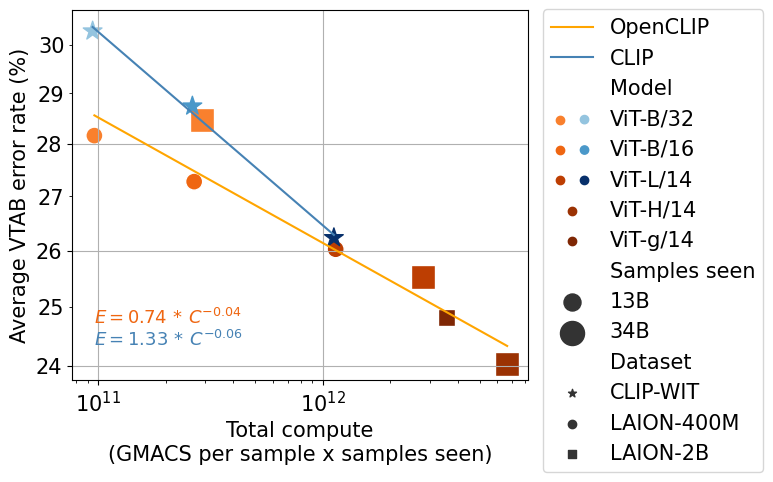

In [5]:
newdf = pd.read_json('scaling_experiment_data_vtab.json')
figsize = (8,5)
from matplotlib.legend_handler import HandlerTuple
from matplotlib.patches import Patch
import matplotlib.patches as mpatches
from matplotlib.legend_handler import HandlerTuple
from copy import copy
from matplotlib.lines import Line2D
fig, axes = plt.subplots(nrows=1, ncols=1, constrained_layout=True, figsize=figsize)
ax = axes
porange = cm.get_cmap('Oranges', 12)
new_porange = porange(np.linspace(0.5, 1, len(arch_order) ))
#task = "imagenet"
#task = "retrieval"
# names = {
#     "imagenet": ('imagenet1k', 'imagenet_robustness'),
#     "retrieval": ('mscoco_captions', 'flickr30k'),
# }[task]
#for ax, tgt in zip(axes, ('imagenet1k', 'mscoco_captions')):
#for ax, tgt in zip(axes, ('imagenet1k', 'vtab')):
#for ax, tgt in zip(axes, ('imagenet1k', 'imagenet_robustness')):
#for ax, tgt in zip(axes, ('imagenet1k', 'mscoco_captions')):
#for ax, tgt in zip(axes, ('mscoco_captions', 'flickr30k')):
def get_formula_text(coefs):
    return f"$E = {10**(coefs[1]):.2f} \/*\/ C^{{ {coefs[0]:.2f} }}$"
def get_rotn(x0, y0, x1, y1):
    p1 = ax.transData.transform_point((x0, y0))
    p2 = ax.transData.transform_point((x1, y1))
    dy = (p2[-1] - p1[-1])
    dx = (p2[0] - p1[0])
    return np.degrees(np.arctan2(dy, dx))

tgt = 'vtab'
fewshot_k = -1

d, d_openai, d_openclip, target_pretty, metric_pretty, metric_pretty2, metric = build_df2(tgt, fewshot_k)
line_fit_loglog_openclip = lstsq(np.log10(d_openclip.gmacs_total), np.log10(d_openclip.err1))
line_fit_loglog_openai = lstsq(np.log10(d_openai.gmacs_total), np.log10(d_openai.err1))
print(tgt, line_fit_loglog_openclip, line_fit_loglog_openai)
d["styles"] = d.upstream_dataset.apply(lambda f:upstream_dataset_styles[f])
#d = d.sort_values(by="gmacs")
d = d.sort_values(by=["Dataset source", "data_scale"])
sns.scatterplot(
    #data=d[d.upstream_dataset != "LAION-80M"],
    #data=d_openclip.sort_values(by="data_scale"),
    data=d,
    #data=d,
    x='gmacs_total',
    y='err1%',

    #hue='Dataset',
    #palette=upstream_colors2,
    #hue_order=upstream_order + ["CLIP-WIT"],

    hue="Model",
    #palette="Oranges",
    palette=new_porange,
    hue_order=arch_order,

    #size="Dataset",
    #size_order=upstream_order,
    #sizes=upstream_sizes,

    size="Samples seen",
    size_order=samples_seen_order,
    sizes=samples_seen_sizes,

    #size="Model",
    #size_order=arch_order,
    #sizes=arch_sizes,

    style='Dataset',
    markers=upstream_dataset_styles,

    #style="Model",
    #markers=model_styles,

    ax=ax,
    #color='blue',
    #alpha=0.5,
    #style='+',
    s=120,
    #alpha=0.8
)
def pred(g, params):
    a, b = params
    return 10**(b) * g**a
d = d.sort_values(by='gmacs_total')

# OpenCLIP line
x = d_openclip.gmacs_total.values
y = (100* pred(d_openclip.gmacs_total, line_fit_loglog_openclip)).values
ax.plot(x, y, color='orange', label='OpenCLIP')#, linestyle='dashed')
#rotn = get_rotn(x[0], y[0], x[-1], y[-1])+5
#ax.annotate(get_formula_text(line_fit_loglog_openclip), xy=(x[0],y[0]-1.5), ha='center', va='center', rotation=rotn, fontsize=13)
xm = x.min()
ym = y.min()
shift = (y[-1] - y[-2]) * 0.65
print(get_formula_text(line_fit_loglog_openclip))
ax.annotate(get_formula_text(line_fit_loglog_openclip), xy=(xm, ym-shift), rotation=0, fontsize=13, color=new_porange[1])
#ax.annotate(get_formula_text(line_fit_loglog_openclip), xy=(xm, ym+1), rotation=0, fontsize=13, color=new_porange[1])
# OpenAI line
# x = d_openai.gmacs_total.values
# y = 100*pred(d_openai.gmacs_total, line_fit_loglog_openai).values
# ax.plot(x, y, color='steelblue',ms=10, label="CLIP")

# #rotn = get_rotn(x[0], y[0], x[-1], y[-1])+5
# #ax.annotate(get_formula_text(line_fit_loglog_openai), xy=(x[0],y[0]-8), ha='center', va='center', rotation=rotn, fontsize=13)
# ax.annotate(get_formula_text(line_fit_loglog_openai), xy=(xm, ym),rotation=0, fontsize=13, color='steelblue')

    # OpenAI line
x = d_openai.gmacs_total.values
y = 100*pred(d_openai.gmacs_total, line_fit_loglog_openai).values
ax.plot(x, y, color='steelblue', ms=10, label="CLIP")
openai_cols = cm.get_cmap('Blues')
openai_cols = [openai_cols(0.4), openai_cols(0.6), openai_cols(1.0)]
ax.scatter(d_openai.gmacs_total.values, d_openai['err1%'].values, marker='*', s=200, c=openai_cols)
#sns.scatter(x='gmacs_total', y='err1%', data=d_openai,ax=ax,fig=fig)
#ax.scatter(d_openclip.gmacs_total.values, d_openclip['err1%'].values, marker='*', s=150, color='steelblue')

#rotn = get_rotn(x[0], y[0], x[-1], y[-1])+5
#ax.annotate(get_formula_text(line_fit_loglog_openai), xy=(x[0],y[0]-8), ha='center', va='center', rotation=rotn, fontsize=13)
ax.annotate(get_formula_text(line_fit_loglog_openai), xy=(xm, ym),rotation=0, fontsize=13, color='steelblue')
ax.set_xscale('log')
ax.set_yscale('log')
ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%d'))
ax.yaxis.set_minor_formatter(mticker.ScalarFormatter())
# if iimod3 == 0:
#     ax.text(.5,.9,'10 examples per class',
#         horizontalalignment='center',
#         transform=ax.transAxes, fontsize=12)
# elif iimod3 == 1:
#     ax.text(.5,.9,'25 examples per class',
#         horizontalalignment='center',
#         transform=ax.transAxes, fontsize=12)
# elif iimod3 == 2:
#     ax.text(.5,.9,'Full dataset',
#         horizontalalignment='center',
#         transform=ax.transAxes, fontsize=12)

ax.set_ylabel(f"Average {target_pretty} {metric_pretty2}")
minv = d_openclip['err1%'].min()
maxv = d_openclip['err1%'].max()

unit = 5
minv = unit * (minv // unit + 1)
maxv = unit * (maxv // unit + 1)
#ax.set_ylim(minv-unit-1,maxv)
#ax.minorticks_on()

ax.grid(True,)
ax.set_yticks( np.arange(24, 30, 2) )
#if ii == 0:
#ax.legend(bbox_to_anchor=(-1,-0.4), ncol=5, )
#lab, hand = ax.get_axis_labels_handles()
#ax.legend(lab, hand, bbox_to_anchor=(0.5,-0.4), ncol=5, )#.legendHandles[-1]._legmarker.set_marker('*')
#h, l = ax.get_legend_handles_labels()
#h[-1] = Line2D([0], [0], color='steelblue',ms=10, label="CLIP", marker='*')

from matplotlib.lines import Line2D
handles, labels = ax.get_legend_handles_labels()#
start = 3-2
end = 6-2
for i in range(start, end):
    hnew = copy(handles[i])
    hnew.set_facecolors([openai_cols[i-start], "none"])
    hnew.set_edgecolors([openai_cols[i-start], "none"])
    handles[i] = (handles[i], hnew)
#handles[-1] = Line2D([0], [0], color='steelblue',ms=10, label="CLIP", marker='*')
handles = handles[-2:] + handles[:-2]
labels = labels[-2:] + labels[:-2]
ax.legend(handles, labels, bbox_to_anchor=(1.01,1.03), handler_map={tuple: HandlerTuple(ndivide=None)})
    
# else:
#     ax.legend().set_visible(False)

# sns.scatterplot(
#     #data=d[d.upstream_dataset != "LAION-80M"],
#     data=d_openai.sort_values(by="data_scale"),
#     #data=d,
#     x='gmacs_total',
#     y='err1%',

#     #hue='Dataset',
#     #palette=upstream_colors2,
#     #hue_order=upstream_order + ["CLIP-WIT"],

#     hue="Dataset",

#     # size="Samples seen",
#     # size_order=samples_seen_order,
#     # sizes=samples_seen_sizes,
#     s = 400,

#     style='Dataset',
#     markers=upstream_dataset_styles,

#     ax=ax,
#     legend=False
# )

ax.set_xlabel("Total compute\n(GMACS per sample x samples seen)")

#ax.legend().set_visible(False)
    
#plt.yticks(np.arange(int(d[metric].min())-2, int(d[metric].max())+2, 10))
#plt.legend(loc='best')
#plt.yticks([50, 45, 40, 30, 25,])
#plt.legend(bbox_to_anchor=(1,1))
#plt.legend(loc='none')
#ax.legend().set_visible(False)
#h[-1].set_marker('*')

plt.tight_layout()
plt.savefig(f"imagenet_cifar_lp_vtab.pdf", bbox_inches='tight')
